In [1]:
# References
# Reshaping tensors with none: https://stackoverflow.com/questions/47026042/how-to-reshape-a-tensor-with-multiple-none-dimensions
# Reshaping tensors with none in batch: https://stackoverflow.com/questions/55003704/reshape-a-tensor-with-none-for-batch-size

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import backend as K
import glob
import PIL
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
np.random.seed(101)

2023-02-23 13:27:10.694822: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 13:27:10.916914: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-23 13:27:11.613033: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/cudnn-8.4/8.4/lib64:/cm/local/apps/cuda/libs/current/lib64:/cm/shared/apps/cuda11.2/toolkit/11.2.0/targets/x86_64-linux/lib:/cm/local/apps/gcc/7.2.0/lib:/cm/local/apps/gcc/7.2.0/lib64:/hom

# Data preprocessing

In [2]:
!git clone https://github.com/Shankar0x/Datasets.git imgs
from PIL import Image

fatal: destination path 'imgs' already exists and is not an empty directory.


X_train shape:  (200, 192, 256, 3)
Y_train shape:  (200, 192, 256)


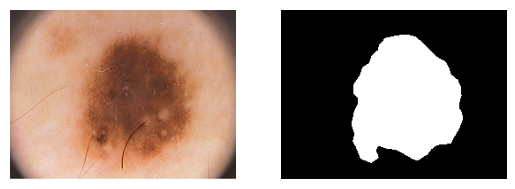

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts


filelist_trainx = sorted(glob.glob('imgs/Resized_Skin_Lesion_Dataset/Trainx/*.bmp'), key=numericalSort)
x_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob('imgs/Resized_Skin_Lesion_Dataset/Trainy/*.bmp'), key=numericalSort)
y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

# filelist_trainx = sorted(glob.glob('imgs/Electron_Microscopy_Dataset/images/*.tif'), key=numericalSort)
# x_train = np.array([np.array(Image.open(fname).convert('RGB')) for fname in filelist_trainx])

# filelist_trainy = sorted(glob.glob('imgs/Electron_Microscopy_Dataset/masks/*.tif'), key=numericalSort)
# y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

# filelist_trainx = sorted(glob.glob('imgs/Skin_Lesion_Dataset/trainx/*.jpg'), key=numericalSort)
# x_train = np.array([np.array(Image.open(fname).convert('RGB')) for fname in filelist_trainx])

# filelist_trainy = sorted(glob.glob('imgs/Skin_Lesion_Dataset/trainy/*.jpg'), key=numericalSort)
# y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])


print("X_train shape: ",x_train.shape)
print("Y_train shape: ",y_train.shape)
plt.subplot(1,2,1)
plt.imshow(x_train[0].astype('uint8'))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(y_train[0].astype('uint8'),cmap = plt.cm.binary_r)
plt.axis('off')
plt.show()

In [4]:
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.25,random_state=101)

In [5]:
print("X_train shape: ",x_train.shape)
print("Y_train shape: ",y_train.shape)
print("X_test shape: ",x_test.shape)
print("Y_test shape: ",y_test.shape)

X_train shape:  (150, 192, 256, 3)
Y_train shape:  (150, 192, 256)
X_test shape:  (50, 192, 256, 3)
Y_test shape:  (50, 192, 256)


In [6]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [7]:
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    x_nois = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
        return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [8]:
def img_augmentation(x_test, y_test):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    x_nois = []
    for idx in range(len(x_test)):
        x,y = random_rotation(x_test[idx], y_test[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        
        x,y = horizontal_flip(x_test[idx], y_test[idx])
        x_flip.append(x)
        y_flip.append(y)

    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [9]:
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(x_train, y_train)
x_rotated_t, y_rotated_t, x_flipped_t, y_flipped_t = img_augmentation(x_test, y_test)

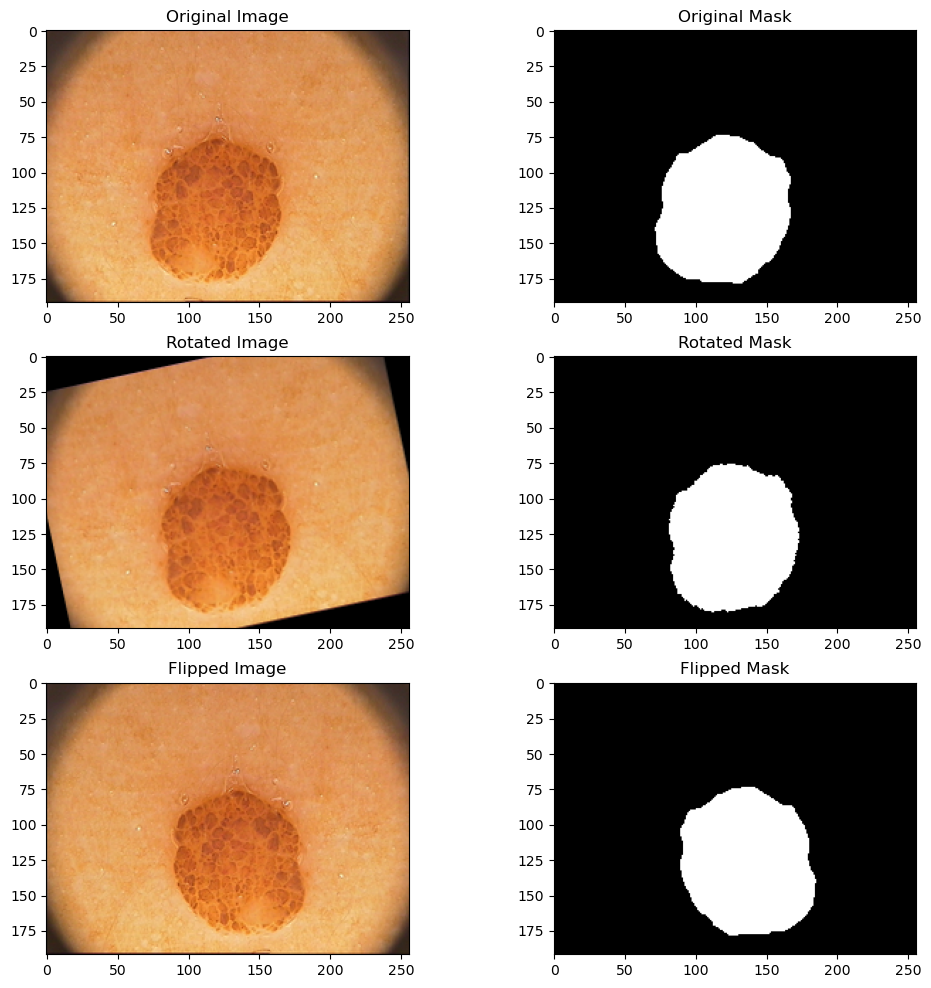

In [10]:
img_num = 114
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(x_train[img_num])
plt.title('Original Image')
plt.subplot(3,2,2)
plt.imshow(y_train[img_num], plt.cm.binary_r)
plt.title('Original Mask')
plt.subplot(3,2,3)
plt.imshow(x_rotated[img_num])
plt.title('Rotated Image')
plt.subplot(3,2,4)
plt.imshow(y_rotated[img_num], plt.cm.binary_r)
plt.title('Rotated Mask')
plt.subplot(3,2,5)
plt.imshow(x_flipped[img_num])
plt.title('Flipped Image')
plt.subplot(3,2,6)
plt.imshow(y_flipped[img_num], plt.cm.binary_r)
plt.title('Flipped Mask')
plt.show()

In [11]:
x_train_full = np.concatenate([x_train, x_rotated, x_flipped])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.20, random_state = 101)

In [13]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(360, 192, 256, 3)
(360, 192, 256)
(50, 192, 256, 3)
(50, 192, 256)
(90, 192, 256, 3)
(90, 192, 256)


# Accuracy of model

In [14]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

# Adding combined connections

In [15]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam, SGD

In [16]:
from keras.layers import concatenate
def segnet_w_skip(epochs_num,savename):

    # Encoding layer
    img_input = Input(shape= (192, 256, 3))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    drop_1 = x
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    drop_2 = x

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    drop_3 = x

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    drop_4 = x
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = concatenate([drop_4,x], axis = 3)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = concatenate([drop_3,x], axis = 3)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = concatenate([drop_2,x], axis = 3)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = concatenate([drop_1,x], axis = 3)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    pred = Reshape((192,256))(x)
    
    model = Model(inputs=img_input, outputs=pred)
    
    model.compile(optimizer= SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False), loss= ["binary_crossentropy"]
                  , metrics=[accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 2, validation_data= (x_val, y_val), verbose=1)
    
    model.save(savename)
    return model,hist

In [17]:
model, hist = segnet_w_skip(100, 'segnet_w_comb_100_epoch.h5')

2023-02-21 12:23:19.829007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 12:23:20.605176: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14493 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 192, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn1 (BatchNormalization)       (None, 192, 256, 64  256         ['conv1[0][0]']                  
                                )                                                             

                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 12, 16, 512)  0          ['activation_9[0][0]']           
                                                                                                  
 conv11 (Conv2D)                (None, 12, 16, 512)  2359808     ['max_pooling2d_3[0][0]']        
                                                                                                  
 bn11 (BatchNormalization)      (None, 12, 16, 512)  2048        ['conv11[0][0]']                 
                                                                                                  
 activation_10 (Activation)     (None, 12, 16, 512)  0           ['bn11[0][0]']                   
                                                                                                  
 conv12 (Conv2D)                (None, 12, 16, 512)  2359808     ['activation_10[0][0]']          
          

 deconv8 (Conv2DTranspose)      (None, 48, 64, 256)  590080      ['activation_19[0][0]']          
                                                                                                  
 bn21 (BatchNormalization)      (None, 48, 64, 256)  1024        ['deconv8[0][0]']                
                                                                                                  
 activation_20 (Activation)     (None, 48, 64, 256)  0           ['bn21[0][0]']                   
                                                                                                  
 deconv9 (Conv2DTranspose)      (None, 48, 64, 128)  295040      ['activation_20[0][0]']          
                                                                                                  
 bn22 (BatchNormalization)      (None, 48, 64, 128)  512         ['deconv9[0][0]']                
                                                                                                  
 activatio

/home/ok_sikha/anaconda3/envs/tf_gpu_segnet/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Total params: 36,527,109
Trainable params: 36,511,235
Non-trainable params: 15,874
__________________________________________________________________________________________________


2023-02-21 12:23:22.202115: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 141557760 exceeds 10% of free system memory.
2023-02-21 12:23:22.424294: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 141557760 exceeds 10% of free system memory.


Epoch 1/100


2023-02-21 12:23:26.260441: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


180/180 [==============================] - 15s 49ms/step - loss: 0.4681 - accuracy: 0.8309 - val_loss: 0.4398 - val_accuracy: 0.8389
Epoch 2/100
180/180 [==============================] - 8s 44ms/step - loss: 0.3930 - accuracy: 0.8793 - val_loss: 0.3983 - val_accuracy: 0.8831
Epoch 3/100
180/180 [==============================] - 8s 43ms/step - loss: 0.3497 - accuracy: 0.8986 - val_loss: 0.3177 - val_accuracy: 0.8946
Epoch 4/100
180/180 [==============================] - 8s 43ms/step - loss: 0.3270 - accuracy: 0.9036 - val_loss: 0.2863 - val_accuracy: 0.9055
Epoch 5/100
180/180 [==============================] - 8s 44ms/step - loss: 0.3109 - accuracy: 0.9055 - val_loss: 0.2640 - val_accuracy: 0.9087
Epoch 6/100
180/180 [==============================] - 8s 43ms/step - loss: 0.2980 - accuracy: 0.9121 - val_loss: 0.3352 - val_accuracy: 0.8898
Epoch 7/100
180/180 [==============================] - 8s 43ms/step - loss: 0.2896 - accuracy: 0.9126 - val_loss: 0.2634 - val_accuracy: 0.9166
Epo

In [18]:
def enhance(img):
    sub = (model.predict(img.reshape(1,192,256,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub

1/1 [==============================] - 0s 36ms/step


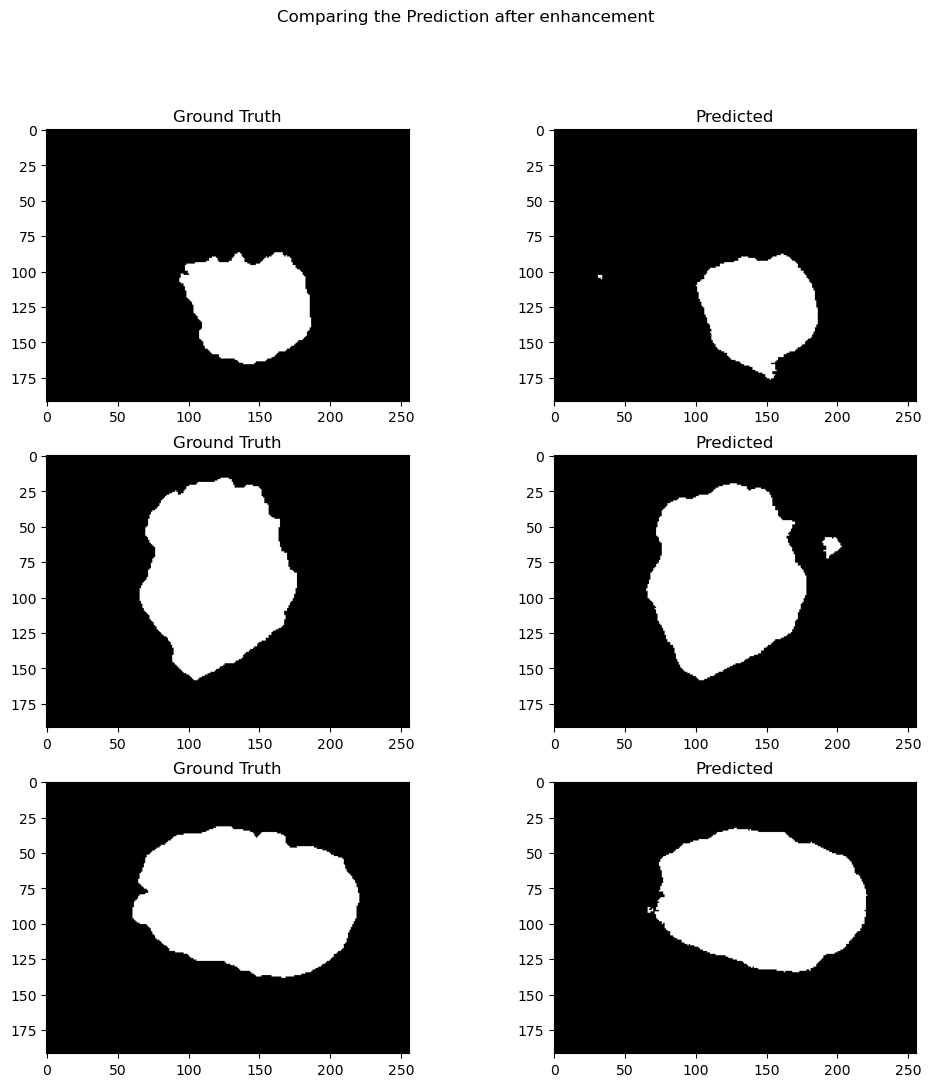

In [19]:
plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(y_test[43],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(enhance(x_test[43]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,3)
plt.imshow(y_test[32],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,4)
plt.imshow(enhance(x_test[32]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,5)
plt.imshow(y_test[21],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,6)
plt.imshow(enhance(x_test[21]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted')
plt.show()

In [20]:
y_pred_test = np.full_like(y_test,fill_value = 0)
for i in range(y_test.shape[0]):
  y_pred_test[i] = enhance(x_test[i]).reshape(192,256)

1/1 [==============================] - 0s 35ms/step


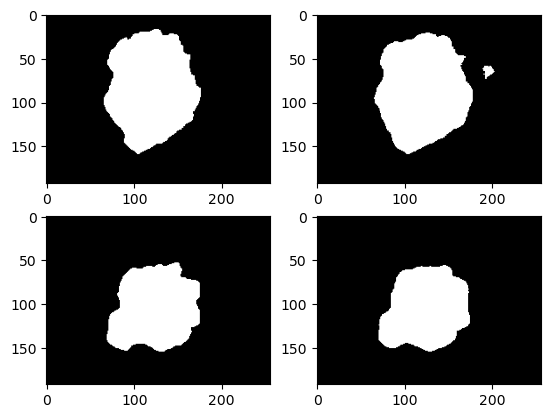

In [21]:
plt.subplot(2,2,1)
plt.imshow(y_test[32],cmap='gray')
plt.subplot(2,2,2)
plt.imshow(y_pred_test[32],cmap='gray')
plt.subplot(2,2,3)
plt.imshow(y_test[23],cmap='gray')
plt.subplot(2,2,4)
plt.imshow(y_pred_test[23],cmap='gray')

In [22]:
from keras.metrics import MeanIoU 
num_classes = 2
IOU_Keras = MeanIoU(num_classes = num_classes)
IOU_Keras.update_state(y_test, y_pred_test)
print("MeanIoU: ",IOU_Keras.result().numpy())

MeanIoU:  0.8491114


### Adding softmax layers

In [16]:
def softmax_image(image):
    dim = tf.reduce_prod(image.shape[1:])
    return tf.reshape(tf.math.softmax(tf.reshape(image, [-1, dim])), [-1] + image.shape.as_list()[1:])

In [17]:
from keras.layers import concatenate
def segnet_smax_skip(epochs_num,savename):

    # Encoding layer
    img_input = Input(shape= (192, 256, 3))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = softmax_image(x)
    x = MaxPooling2D()(x)
    drop_1 = x
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = softmax_image(x)
    x = MaxPooling2D()(x)
    drop_2 = x

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = softmax_image(x)
    x = MaxPooling2D()(x)
    drop_3 = x

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = softmax_image(x)
    x = MaxPooling2D()(x)
    drop_4 = x
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = concatenate([drop_4,x], axis = 3)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = concatenate([drop_3,x], axis = 3)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = concatenate([drop_2,x], axis = 3)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = concatenate([drop_1,x], axis = 3)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    pred = Reshape((192,256))(x)
    
    model = Model(inputs=img_input, outputs=pred)
    
    model.compile(optimizer= SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False), loss= ["binary_crossentropy"]
                  , metrics=[accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, validation_data= (x_val, y_val), verbose=1)
    
    model.save(savename)
    return model,hist

In [18]:
model, hist = segnet_smax_skip(100, 'segnet_w_comb_100_epoch.h5')

2023-02-23 13:27:23.655191: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 13:27:24.407312: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 343 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 192, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn1 (BatchNormalization)       (None, 192, 256, 64  256         ['conv1[0][0]']                  
                                )                                                             

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 24, 32, 256)  0          ['tf.reshape_5[0][0]']           
                                                                                                  
 conv8 (Conv2D)                 (None, 24, 32, 512)  1180160     ['max_pooling2d_2[0][0]']        
                                                                                                  
 bn8 (BatchNormalization)       (None, 24, 32, 512)  2048        ['conv8[0][0]']                  
                                                                                                  
 activation_7 (Activation)      (None, 24, 32, 512)  0           ['bn8[0][0]']                    
                                                                                                  
 conv9 (Conv2D)                 (None, 24, 32, 512)  2359808     ['activation_7[0][0]']           
          

                                                                                                  
 activation_16 (Activation)     (None, 24, 32, 512)  0           ['bn17[0][0]']                   
                                                                                                  
 deconv5 (Conv2DTranspose)      (None, 24, 32, 512)  2359808     ['activation_16[0][0]']          
                                                                                                  
 bn18 (BatchNormalization)      (None, 24, 32, 512)  2048        ['deconv5[0][0]']                
                                                                                                  
 activation_17 (Activation)     (None, 24, 32, 512)  0           ['bn18[0][0]']                   
                                                                                                  
 deconv6 (Conv2DTranspose)      (None, 24, 32, 256)  1179904     ['activation_17[0][0]']          
          

Total params: 36,527,109
Trainable params: 36,511,235
Non-trainable params: 15,874
__________________________________________________________________________________________________


/home/ok_sikha/anaconda3/envs/tf_gpu_segnet/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2023-02-23 13:27:35.735508: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 135.00MiB (rounded to 141557760)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-02-23 13:27:35.735616: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2023-02-23 13:27:35.735650: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (256): 	Total Chunks: 59, Chunks in use: 59. 14.8KiB allocated for chunks. 14.8KiB in use in bin. 5.2KiB client-requested in use in bin.
2023-02-23 13:

2023-02-23 13:27:35.738081: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 2aadd002ca00 of size 256 next 193
2023-02-23 13:27:35.738093: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 2aadd002cb00 of size 256 next 194
2023-02-23 13:27:35.738106: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 2aadd002cc00 of size 256 next 195
2023-02-23 13:27:35.738118: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 2aadd002cd00 of size 256 next 197
2023-02-23 13:27:35.738130: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 2aadd002ce00 of size 256 next 198
2023-02-23 13:27:35.738143: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 2aadd002cf00 of size 256 next 196
2023-02-23 13:27:35.738155: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 2aadd002d000 of size 256 next 199
2023-02-23 13:27:35.738167: I tensorflow/core/common_runtime/bfc_allocator.cc:1089] InUse at 2aadd002d100 of si

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [30]:
tf.__version__

'2.10.0'

In [22]:
def enhance(img):
    sub = (model.predict(img.reshape(1,192,256,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub

1/1 [==============================] - 0s 33ms/step


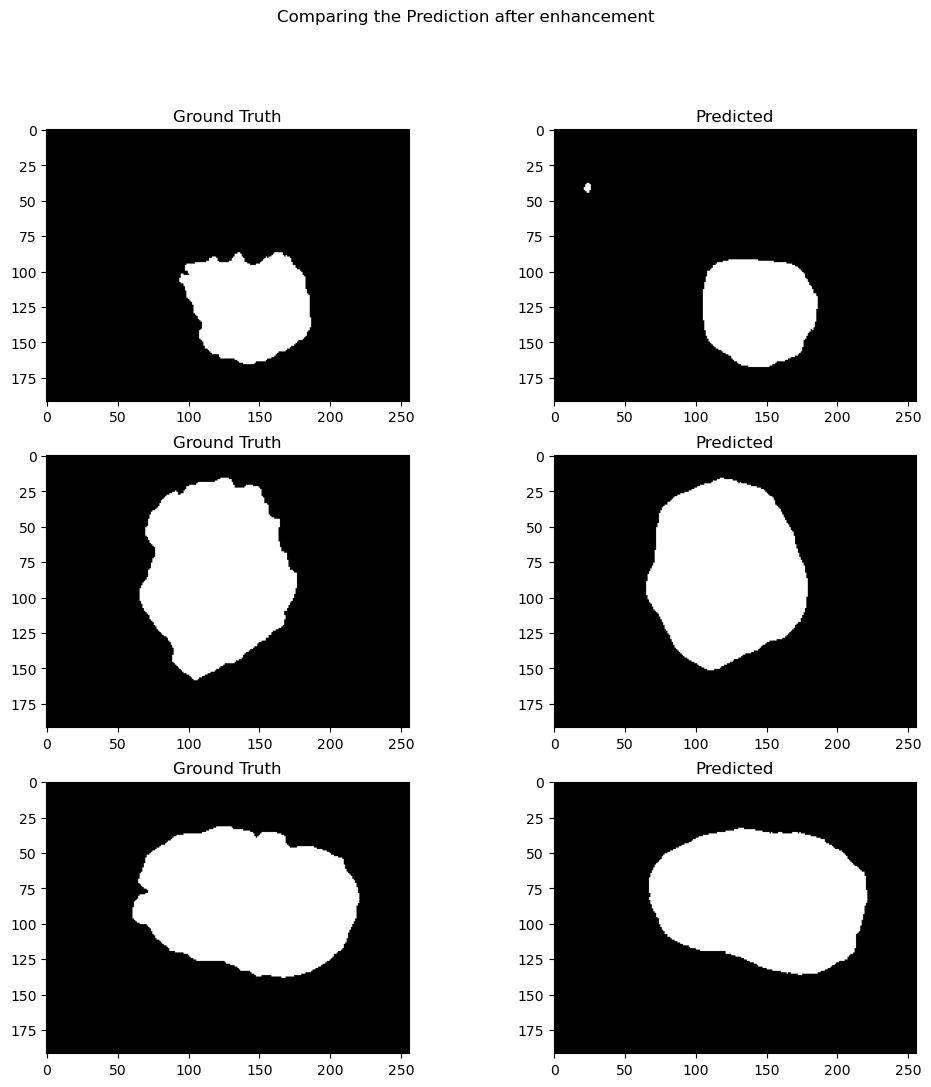

In [23]:
plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(y_test[43],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(enhance(x_test[43]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,3)
plt.imshow(y_test[32],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,4)
plt.imshow(enhance(x_test[32]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,5)
plt.imshow(y_test[21],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,6)
plt.imshow(enhance(x_test[21]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted')
plt.show()

In [24]:
y_pred_test = np.full_like(y_test,fill_value = 0)
for i in range(y_test.shape[0]):
  y_pred_test[i] = enhance(x_test[i]).reshape(192,256)

1/1 [==============================] - 0s 30ms/step


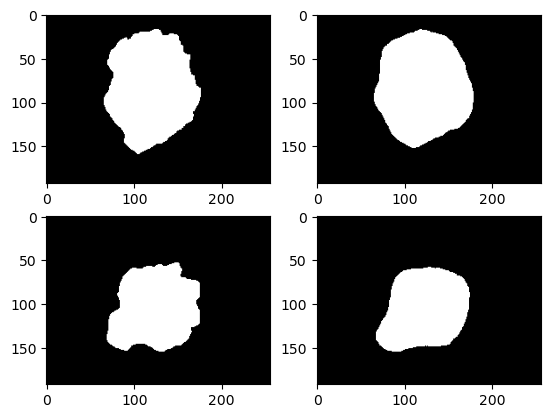

In [25]:
plt.subplot(2,2,1)
plt.imshow(y_test[32],cmap='gray')
plt.subplot(2,2,2)
plt.imshow(y_pred_test[32],cmap='gray')
plt.subplot(2,2,3)
plt.imshow(y_test[23],cmap='gray')
plt.subplot(2,2,4)
plt.imshow(y_pred_test[23],cmap='gray')

In [26]:
from keras.metrics import MeanIoU 
num_classes = 2
IOU_Keras = MeanIoU(num_classes = num_classes)
IOU_Keras.update_state(y_test, y_pred_test)
print("MeanIoU: ",IOU_Keras.result().numpy())

MeanIoU:  0.87558174


### Working with lesser number of layers